In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures
import time
import itertools
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

In [2]:
np.random.seed(0)
X = np.random.randn(100)
noise = np.random.randn(100)
b_0, b_1, b_2, b_3 = 3, 10, -1.2, 7
y = b_0 + b_1 * X + b_2 * (X**2) + b_3 * (X**3) + noise

In [3]:
# Pre-processing X to data frame polynominal
X_poly = PolynomialFeatures(degree=10).fit_transform(X.reshape(-1,1))[:,1:]
X_name = ['X^{}'.format(x) for x in range(2,11)]
X_name.insert(0, 'X')
X_poly = pd.DataFrame(X_poly, columns=X_name)
X_poly

,X,X^2,X^3,X^4,X^5,X^6,X^7,X^8,X^9,X^10
0,1.764052,3.111881,5.489520,9.683801e+00,1.708273e+01,3.013483e+01,5.315943e+01,9.377601e+01,1.654258e+02,2.918198e+02
1,0.400157,0.160126,0.064075,2.564027e-02,1.026014e-02,4.105668e-03,1.642913e-03,6.574234e-04,2.630727e-04,1.052704e-04
2,0.978738,0.957928,0.937561,9.176261e-01,8.981156e-01,8.790198e-01,8.603301e-01,8.420377e-01,8.241343e-01,8.066115e-01
3,2.240893,5.021602,11.252875,2.521649e+01,5.650746e+01,1.266272e+02,2.837580e+02,6.358714e+02,1.424920e+03,3.193093e+03
4,1.867558,3.487773,6.513618,1.216456e+01,2.271802e+01,4.242722e+01,7.923529e+01,1.479765e+02,2.763547e+02,5.161084e+02
...,...,...,...,...,...,...,...,...,...,...
95,0.706573,0.499246,0.352754,2.492462e-01,1.761107e-01,1.244351e-01,8.792249e-02,6.212367e-02,4.389492e-02,3.101497e-02
96,0.010500,0.000110,0.000001,1.215516e-08,1.276294e-10,1.340112e-12,1.407120e-14,1.477479e-16,1.551356e-18,1.628927e-20
97,1.785870,3.189333,5.695736,1.017185e+01,1.816560e+01,3.244141e+01,5.793616e+01,1.034665e+02,1.847777e+02,3.299891e+02
98,0.126912,0.016107,0.002044,2.594251e-04,3.292418e-05,4.178477e-06,5.302993e-07,6.730139e-08,8.541360e-09,1.084002e-09


## Perform Best subset selection

In [4]:
# Perform Best subset selection
def process_subset(feature_set, X, y):
    # Fit model on feature_set and calculate R2
    model = sm.OLS(y,sm.add_constant(X[list(feature_set)]))
    regr = model.fit()
    R2 = regr.rsquared

    # Return dict include model and useful information 
    return {'model': regr, 'features': regr.model.exog_names,  'R2': R2}

In [5]:
def get_best_subset(k, X, y):
    
    # Want to create list of models with k predictors 
    results = []
    
    # Start counting time
    tic = time.time()
    
    # Process combinations features to create model & retult

    for feature_set in itertools.combinations(X.columns, k):
        results.append(process_subset(feature_set, X, y))
    
    # Wrap result up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest R2
    best_model = models.loc[models['R2'].argmax()]
    
    toc = time.time()
    print("Processed {:5} models on {:2} predictors in {:6.2f} seconds.".format(models.shape[0], k, (toc-tic)))
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [6]:
models_best = pd.DataFrame(columns=['model', 'features', 'R2'])

tic = time.time()
for i in range(1,11):
    models_best.loc[i] = get_best_subset(i, X_poly, y)

toc = time.time()
print("Total elapsed time: {:.2f} seconds.".format((toc-tic)))

Processed    10 models on  1 predictors in   0.04 seconds.
Processed    45 models on  2 predictors in   0.12 seconds.
Processed   120 models on  3 predictors in   0.24 seconds.
Processed   210 models on  4 predictors in   0.43 seconds.
Processed   252 models on  5 predictors in   0.52 seconds.
Processed   210 models on  6 predictors in   0.45 seconds.
Processed   120 models on  7 predictors in   0.27 seconds.
Processed    45 models on  8 predictors in   0.11 seconds.
Processed    10 models on  9 predictors in   0.03 seconds.
Processed     1 models on 10 predictors in   0.00 seconds.
Total elapsed time: 2.25 seconds.


In [7]:
# Function add metrics R2_adj, AIC, BIC
def add_metrics_table(models):
    models['R2_adj'] = models.apply(lambda x: x['model'].rsquared_adj, axis=1)
    models['AIC'] = models.apply(lambda x: x['model'].aic, axis=1)
    models['BIC'] = models.apply(lambda x: x['model'].bic, axis=1)

In [8]:
add_metrics_table(models_best)
models_best

,model,features,R2,R2_adj,AIC,BIC
1,<statsmodels.regression.linear_model.Regressio...,"[const, X^3]",0.966704,0.966364,636.435428,641.645768
2,<statsmodels.regression.linear_model.Regressio...,"[const, X, X^3]",0.996194,0.996116,421.547206,429.362716
3,<statsmodels.regression.linear_model.Regressio...,"[const, X, X^2, X^3]",0.998931,0.998897,296.579418,307.000099
4,<statsmodels.regression.linear_model.Regressio...,"[const, X, X^2, X^3, X^5]",0.998968,0.998924,295.075076,308.100926
5,<statsmodels.regression.linear_model.Regressio...,"[const, X, X^2, X^3, X^5, X^7]",0.998973,0.998919,296.534515,312.165536
6,<statsmodels.regression.linear_model.Regressio...,"[const, X, X^2, X^3, X^4, X^7, X^9]",0.999003,0.998939,295.569589,313.805780
7,<statsmodels.regression.linear_model.Regressio...,"[const, X, X^2, X^3, X^5, X^7, X^8, X^9]",0.999007,0.998931,297.207627,318.048988
8,<statsmodels.regression.linear_model.Regressio...,"[const, X, X^2, X^3, X^4, X^6, X^7, X^8, X^9]",0.999014,0.998928,298.443032,321.889563
9,<statsmodels.regression.linear_model.Regressio...,"[const, X, X^2, X^3, X^4, X^5, X^6, X^7, X^9, ...",0.999027,0.998930,299.148024,325.199726
10,<statsmodels.regression.linear_model.Regressio...,"[const, X, X^2, X^3, X^4, X^5, X^6, X^7, X^8, ...",0.999027,0.998918,301.143730,329.800602


In [9]:
# Function display 4 charts on single model
def display_chart_models(models, good_point):
    plt.figure(figsize=(12,12))

    # Plot R2
    plt.subplot(2,2,1)
    sb.lineplot(x=models.index, y=models['R2'])
    max_R2 = models['R2'].max()
    plt.plot(models[models['R2']==max_R2].index, max_R2, 'ro', label='Max R2')
    # Plot Reasonable point
    if good_point != max_R2:
        plt.scatter(good_point, models.loc[good_point, 'R2'], label='Good point: {:,.0f} at {} predictors'.format(models.loc[good_point, 'R2'], good_point))
        plt.scatter([], [], color='white', label='{}'.format(models.loc[good_point, 'features']))
    plt.legend()
    plt.xticks(models.index)

    # Plot R2_adj
    plt.subplot(2,2,2)
    sb.lineplot(x=models.index, y=models['R2_adj'])
    max_R2_adj = models['R2_adj'].max()
    plt.plot(models[models['R2_adj']==max_R2_adj].index, max_R2_adj, 'ro', label=' Max adj R2')
    # Plot Reasonable point
    if good_point != max_R2_adj:
        plt.scatter(good_point, models.loc[good_point, 'R2_adj'], label='Good point: {:,.0f} at {} predictors'.format(models.loc[good_point, 'R2_adj'], good_point))
        plt.scatter([], [], color='white', label='{}'.format(models.loc[good_point, 'features']))
    plt.legend()
    plt.xticks(models.index)

    # Plot AIC
    plt.subplot(2,2,3)
    sb.lineplot(x=models.index, y=models['AIC'])
    min_AIC = models['AIC'].min()
    plt.plot(models[models['AIC']==min_AIC].index, min_AIC, 'ro', label='Min AIC')
    # Plot Reasonable point
    if good_point != min_AIC:
        plt.scatter(good_point, models.loc[good_point, 'AIC'], label='Good point: {:,.0f} at {} predictors'.format(models.loc[good_point, 'AIC'], good_point))
        plt.scatter([], [], color='white', label='{}'.format(models.loc[good_point, 'features']))
    plt.legend()
    plt.xticks(models.index)

    # Plot BIC
    plt.subplot(2,2,4)
    sb.lineplot(x=models.index, y=models['BIC'])
    min_BIC = models['BIC'].min()
    plt.plot(models[models['BIC']==min_BIC].index, min_BIC, 'ro', label='Min BIC')
    # Plot Reasonable point
    if good_point != min_BIC:
        plt.scatter(good_point, models.loc[good_point, 'BIC'], label='Good point: {:,.0f} at {} predictors'.format(models.loc[good_point, 'BIC'], good_point))
        plt.scatter([], [], color='white', label='{}'.format(models.loc[good_point, 'features']))
    plt.legend()
    plt.xticks(models.index)


    plt.show()

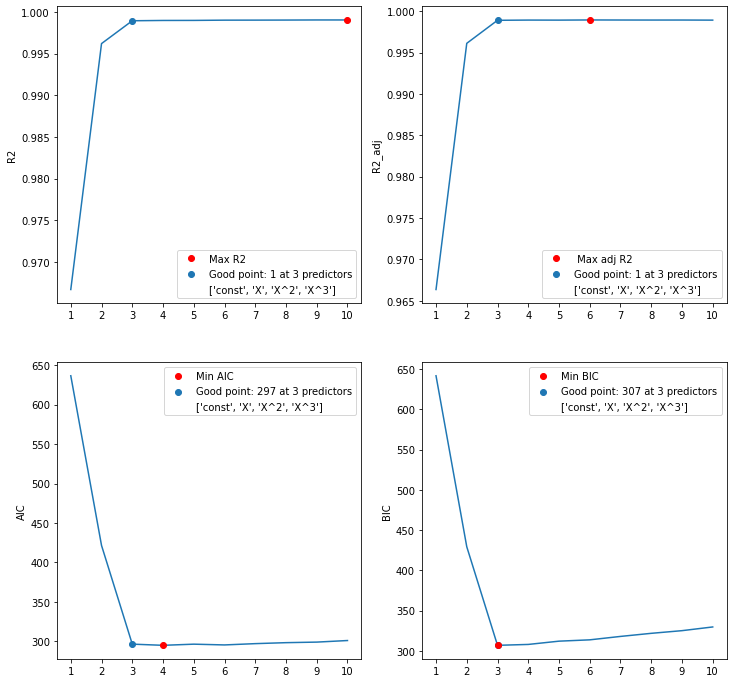

In [10]:
display_chart_models(models_best, 3)

In [11]:
models_best.loc[3,'model'].params

const     3.143159
X        10.162551
X^2      -1.266798
X^3       6.985227
dtype: float64

## Perform Forward Stepwise Selection

In [12]:
# Perform Forward Stepwise Selection
def forward_stepwise(predictors, X, y):
    
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]

    tic = time.time()

    results = []

    for p in remaining_predictors:
        results.append(process_subset(predictors + [p], X, y))

    # Wrap result up in a nice dataframe
    models = pd.DataFrame(results)

    # Choose model with the highest R2
    best_model = models.loc[models['R2'].argmax()]

    toc = time.time()

    print('Processed {:3} models on {:2} predictors in {:6.2f} seconds.'.format(models.shape[0], len(predictors)+1, (toc-tic)))
    return best_model

In [13]:
models_fwd = pd.DataFrame(columns=['model', 'features','R2'])

tic = time.time()
predictors = []

for i in range(1, len(X_poly.columns)+1):
    models_fwd.loc[i] = forward_stepwise(predictors, X_poly, y)
    predictors = list(models_fwd.loc[i,'model'].model.exog_names)
    predictors.remove('const')

toc = time.time()
print('Total elapsed time: {:.2f} seconds.'.format(toc-tic))

Processed  10 models on  1 predictors in   0.03 seconds.
Processed   9 models on  2 predictors in   0.03 seconds.
Processed   8 models on  3 predictors in   0.02 seconds.
Processed   7 models on  4 predictors in   0.02 seconds.
Processed   6 models on  5 predictors in   0.02 seconds.
Processed   5 models on  6 predictors in   0.01 seconds.
Processed   4 models on  7 predictors in   0.01 seconds.
Processed   3 models on  8 predictors in   0.01 seconds.
Processed   2 models on  9 predictors in   0.01 seconds.
Processed   1 models on 10 predictors in   0.00 seconds.
Total elapsed time: 0.19 seconds.


In [14]:
add_metrics_table(models_fwd)
models_fwd

,model,features,R2,R2_adj,AIC,BIC
1,<statsmodels.regression.linear_model.Regressio...,"[const, X^3]",0.966704,0.966364,636.435428,641.645768
2,<statsmodels.regression.linear_model.Regressio...,"[const, X^3, X]",0.996194,0.996116,421.547206,429.362716
3,<statsmodels.regression.linear_model.Regressio...,"[const, X^3, X, X^2]",0.998931,0.998897,296.579418,307.000099
4,<statsmodels.regression.linear_model.Regressio...,"[const, X^3, X, X^2, X^5]",0.998968,0.998924,295.075076,308.100926
5,<statsmodels.regression.linear_model.Regressio...,"[const, X^3, X, X^2, X^5, X^7]",0.998973,0.998919,296.534515,312.165536
6,<statsmodels.regression.linear_model.Regressio...,"[const, X^3, X, X^2, X^5, X^7, X^4]",0.998993,0.998928,296.593410,314.829601
7,<statsmodels.regression.linear_model.Regressio...,"[const, X^3, X, X^2, X^5, X^7, X^4, X^9]",0.999006,0.998931,297.249700,318.091061
8,<statsmodels.regression.linear_model.Regressio...,"[const, X^3, X, X^2, X^5, X^7, X^4, X^9, X^10]",0.999010,0.998923,298.857330,322.303862
9,<statsmodels.regression.linear_model.Regressio...,"[const, X^3, X, X^2, X^5, X^7, X^4, X^9, X^10,...",0.999027,0.998930,299.148024,325.199726
10,<statsmodels.regression.linear_model.Regressio...,"[const, X^3, X, X^2, X^5, X^7, X^4, X^9, X^10,...",0.999027,0.998918,301.143730,329.800602


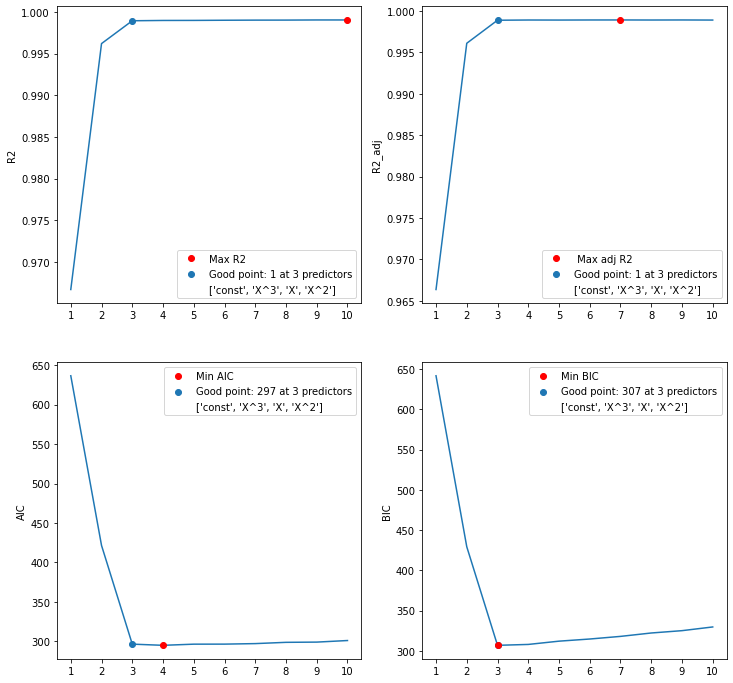

In [15]:
display_chart_models(models_fwd, 3)

## Perform Backward Stepwise Selection

In [16]:
# Perform Backward Stepwise selection
def backward_stepwise(predictors, i, X, y):
    
    tic = time.time()

    results = []

    for p in itertools.combinations(predictors, i):
        results.append(process_subset(p, X, y))

    models = pd.DataFrame(results)

    best_model = models.loc[models['R2'].argmax()]

    toc = time.time()

    print('Processed {:3} models on {:2} predictors in {:5.2f} seconds.'.format(models.shape[0], i, (toc-tic)))
    
    return best_model

In [17]:
models_bwd = pd.DataFrame(columns=['model', 'features','R2'])

tic = time.time()
predictors = X_poly.columns

for i in range(len(X_poly.columns), 0, -1):
    models_bwd.loc[i] = backward_stepwise(predictors, i, X_poly, y)
    predictors = list(models_bwd.loc[i]['model'].model.exog_names)
    predictors.remove('const')

toc = time.time()
print('Total elapsed time: {:.2f} seconds.'.format(toc-tic))

Processed   1 models on 10 predictors in  0.01 seconds.
Processed  10 models on  9 predictors in  0.12 seconds.
Processed   9 models on  8 predictors in  0.02 seconds.
Processed   8 models on  7 predictors in  0.02 seconds.
Processed   7 models on  6 predictors in  0.02 seconds.
Processed   6 models on  5 predictors in  0.01 seconds.
Processed   5 models on  4 predictors in  0.01 seconds.
Processed   4 models on  3 predictors in  0.01 seconds.
Processed   3 models on  2 predictors in  0.01 seconds.
Processed   2 models on  1 predictors in  0.01 seconds.
Total elapsed time: 0.27 seconds.


In [18]:
add_metrics_table(models_bwd)
models_bwd

,model,features,R2,R2_adj,AIC,BIC
10,<statsmodels.regression.linear_model.Regressio...,"[const, X, X^2, X^3, X^4, X^5, X^6, X^7, X^8, ...",0.999027,0.998918,301.143730,329.800602
9,<statsmodels.regression.linear_model.Regressio...,"[const, X, X^2, X^3, X^4, X^5, X^6, X^7, X^9, ...",0.999027,0.998930,299.148024,325.199726
8,<statsmodels.regression.linear_model.Regressio...,"[const, X, X^2, X^3, X^4, X^6, X^7, X^9, X^10]",0.999014,0.998927,298.513440,321.959972
7,<statsmodels.regression.linear_model.Regressio...,"[const, X, X^2, X^3, X^4, X^6, X^7, X^9]",0.999003,0.998928,297.554173,318.395534
6,<statsmodels.regression.linear_model.Regressio...,"[const, X, X^2, X^3, X^4, X^7, X^9]",0.999003,0.998939,295.569589,313.805780
5,<statsmodels.regression.linear_model.Regressio...,"[const, X, X^2, X^3, X^7, X^9]",0.998972,0.998917,296.687799,312.318820
4,<statsmodels.regression.linear_model.Regressio...,"[const, X, X^2, X^3, X^7]",0.998962,0.998919,295.577970,308.603821
3,<statsmodels.regression.linear_model.Regressio...,"[const, X, X^2, X^3]",0.998931,0.998897,296.579418,307.000099
2,<statsmodels.regression.linear_model.Regressio...,"[const, X, X^3]",0.996194,0.996116,421.547206,429.362716
1,<statsmodels.regression.linear_model.Regressio...,"[const, X^3]",0.966704,0.966364,636.435428,641.645768


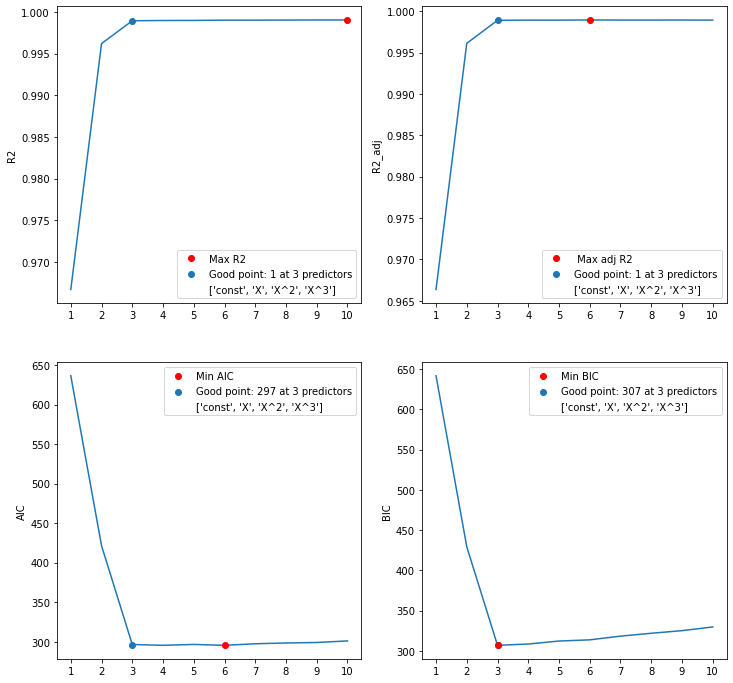

In [19]:
display_chart_models(models_bwd, 3)

In [20]:
# Function display charts on multiple model
def display_chart_multiple_models(list_models):
    plt.figure(figsize=(12,12))

    # Plot R2
    plt.subplot(2,2,1)
    for (models, labels) in list_models:
        sb.lineplot(x=models.index, y=models['R2'], label=labels)
        max_R2 = models['R2'].max()
        plt.scatter(models[models['R2']==max_R2].index, max_R2)
        plt.xticks(models.index)
    plt.legend()

    # Plot R2_adj
    plt.subplot(2,2,2)
    for (models, labels) in list_models:
        sb.lineplot(x=models.index, y=models['R2_adj'], label=labels)
        max_R2_adj = models['R2_adj'].max()
        plt.scatter(models[models['R2_adj']==max_R2_adj].index, max_R2_adj)
        plt.xticks(models.index)
    plt.legend()

    # Plot AIC
    plt.subplot(2,2,3)
    for (models, labels) in list_models:
        sb.lineplot(x=models.index, y=models['AIC'], label=labels)
        min_AIC = models['AIC'].min()
        plt.scatter(models[models['AIC']==min_AIC].index, min_AIC)
        plt.xticks(models.index)
    plt.legend()

    # Plot BIC
    plt.subplot(2,2,4)
    for (models, labels) in list_models:
        sb.lineplot(x=models.index, y=models['BIC'], label=labels)
        min_BIC = models['BIC'].min()
        plt.scatter(models[models['BIC']==min_BIC].index, min_BIC)
        plt.xticks(models.index)
    plt.legend()

    plt.show()

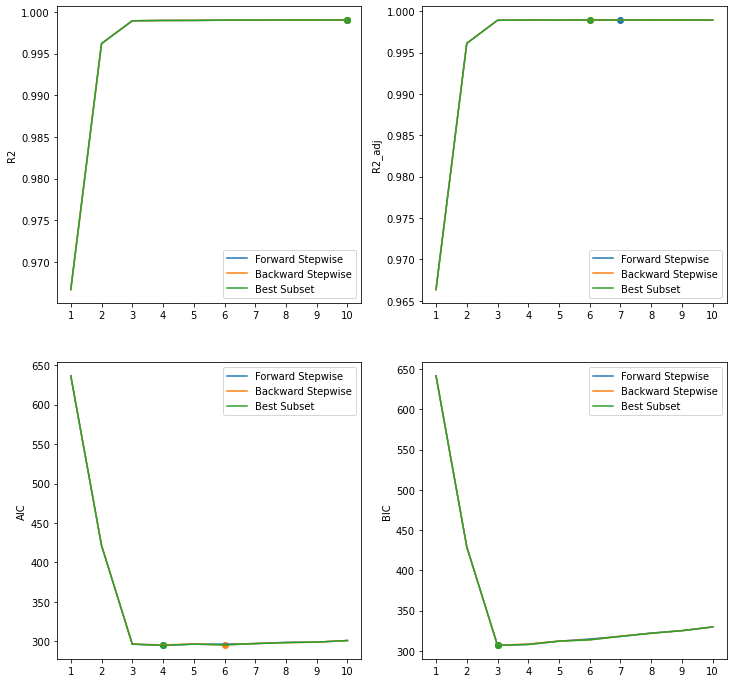

In [21]:
display_chart_multiple_models([[models_fwd,'Forward Stepwise'], [models_bwd, 'Backward Stepwise'], [models_best, 'Best Subset']])

## Perform Lasso to choose number predictors

In [22]:
# Run Lasso CV to calculate mse and identify best alpha
alphas = np.logspace(1, -4, 100)
lassocv = LassoCV(alphas=alphas, normalize=True, cv=10).fit(X_poly, y)
mse_lasso_cv = lassocv.mse_path_.mean(axis=1)
optimal_alpha_lasso = lassocv.alpha_
optimal_alpha_lasso

0.002915053062825176

In [23]:
def display_mse(mse_result, alphas):

    # Plot MSE line
    plt.plot(alphas, mse_result, label='MSE')

    # Plot Min point
    plt.scatter(alphas[mse_result.argmin()], mse_result.min(), label='Min MSE: {:.4f} at alpha: {:.4f}'.format(mse_result.min(), alphas[mse_result.argmin()]))
    plt.xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('Mean Squared Error')
    plt.legend()

In [24]:
def result_model(alphas, X, y):

    lm = Lasso(normalize= True, fit_intercept=True)

    coefs = []

    # Run all model on range alphas
    for a in alphas:
        lm.set_params(alpha = a)
        lm.fit(X, y)
        coefs.append(lm.coef_)

    # Wrap in data frame with Collums names
    results = pd.DataFrame(coefs, columns=X.columns)
    
    return results

In [25]:
def display_model(result_lasso, alphas, optimal_alpha, X, y):

    # Create threshold k where reduce significant coef beta
    optimal_coef = Lasso(normalize=True).set_params(alpha = optimal_alpha).fit(X, y).coef_

    # Draw all feature coef of model
    for i in range(len(result_lasso.columns)):
        label = '{}  : {:.2f}'.format(result_lasso.columns[i], optimal_coef[i]) if np.abs(optimal_coef[i])> 0.01 else ''
        plt.plot(alphas, result_lasso.iloc[:,i], linewidth=3, label=label)

    # Draw a vertical line at threshold k
    plt.axvline(x=optimal_alpha, linestyle='--', linewidth=2, label='Optimal alpha : {:.4f}'.format(optimal_alpha))

    # Scale in log for easier to see, set x,ylabel, legend
    plt.xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('Standardized Coef')
    plt.legend()

In [26]:
def display_number_predictors_by_alpha(result_model, alphas, optimal_alpha):
    # Calculate number predictors follow by changes of alpha
    number_predictors = result_model.astype('bool').sum(axis=1)

    # Plot line, and optimal alpha
    plt.plot(alphas, number_predictors, label='Number Predictors')
    plt.axvline(x=optimal_alpha, linestyle='--', linewidth=2, label='Optimal alpha : {:.4f}'.format(optimal_alpha))

    plt.xscale('log')
    plt.yticks(np.arange(0,len(result_model.columns)+1))
    plt.legend()

In [27]:
result_lasso = result_model(alphas, X_poly, y)

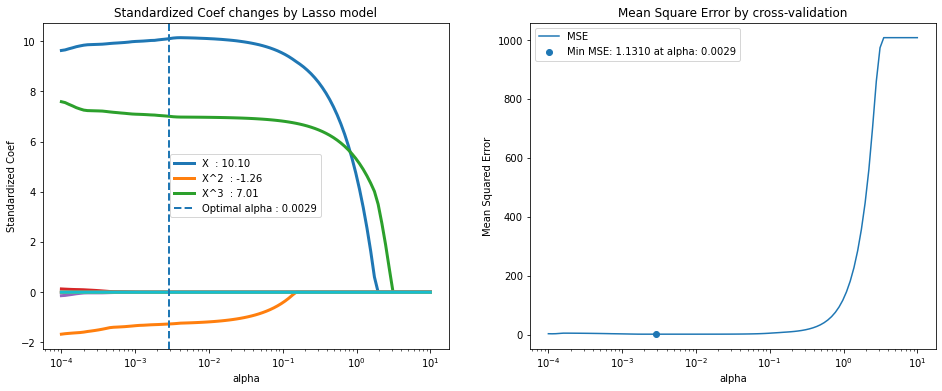

In [28]:
plt.figure(figsize=(16,6))

plot_1 = plt.subplot(1,2,1)
display_model(result_lasso, alphas, optimal_alpha_lasso, X_poly, y)
plt.title('Standardized Coef changes by Lasso model')

plot_2 = plt.subplot(1,2,2)
display_mse(mse_lasso_cv, alphas)
plt.title('Mean Square Error by cross-validation')

plt.show()

## Perform Y_2 = g_0 + g_7 * X^7 + noise

In [47]:
g_0, g_7 = 3, 19
y_2 = g_0 + g_7 * (X**7) + noise

##### Perform Best Subset Selection

In [48]:
models_best_2 = pd.DataFrame(columns=['model', 'features', 'R2'])

tic = time.time()
for i in range(1,11):
    models_best_2.loc[i] = get_best_subset(i, X_poly, y_2)

toc = time.time()

add_metrics_table(models_best_2)
print("Total elapsed time: {:.2f} seconds.".format((toc-tic)))

Processed    10 models on  1 predictors in   0.03 seconds.
Processed    45 models on  2 predictors in   0.10 seconds.
Processed   120 models on  3 predictors in   0.24 seconds.
Processed   210 models on  4 predictors in   0.42 seconds.
Processed   252 models on  5 predictors in   0.52 seconds.
Processed   210 models on  6 predictors in   0.53 seconds.
Processed   120 models on  7 predictors in   0.28 seconds.
Processed    45 models on  8 predictors in   0.11 seconds.
Processed    10 models on  9 predictors in   0.02 seconds.
Processed     1 models on 10 predictors in   0.00 seconds.
Total elapsed time: 2.30 seconds.


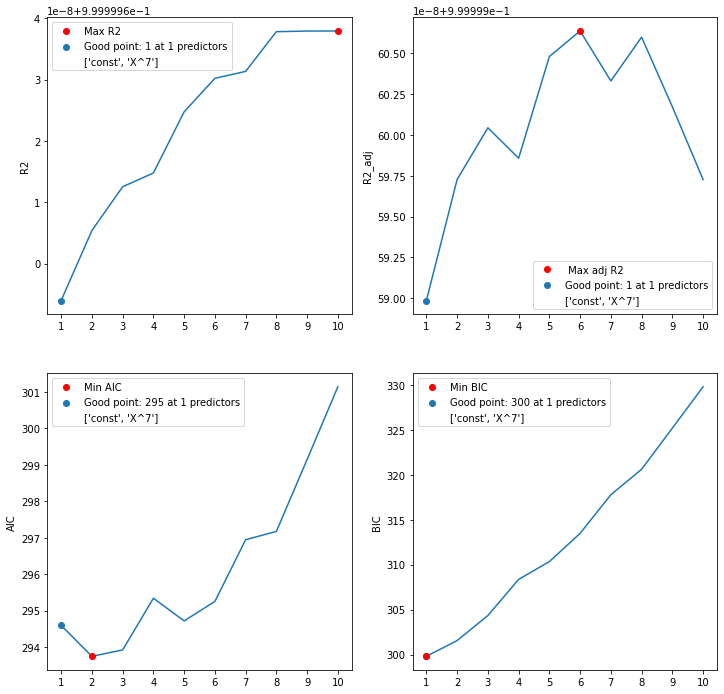

In [53]:
display_chart_models(models_best_2, 1)

In [50]:
# Run Lasso CV to calculate mse and identify best alpha
alphas_2 = np.logspace(4, -8, 400)
lassocv_2 = LassoCV(alphas=alphas_2, normalize=True, cv=10).fit(X_poly, y_2)
mse_lasso_cv_2 = lassocv_2.mse_path_.mean(axis=1)
optimal_alpha_lasso_2 = lassocv_2.alpha_
optimal_alpha_lasso_2

0.008410310505352604

In [51]:
result_lasso_2 = result_model(alphas_2, X_poly, y_2)

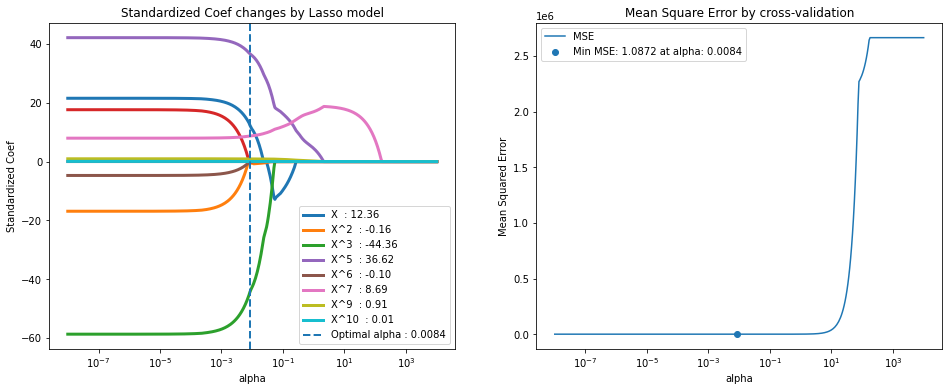

In [52]:
plt.figure(figsize=(16,6))

plot_1 = plt.subplot(1,2,1)
display_model(result_lasso_2, alphas_2, optimal_alpha_lasso_2, X_poly, y_2)
plt.title('Standardized Coef changes by Lasso model')

plot_2 = plt.subplot(1,2,2)
display_mse(mse_lasso_cv_2, alphas_2)
plt.title('Mean Square Error by cross-validation')

plt.show()

## Note that Lasso is not always outperform or perform well than other linear choosing predictors methods, so be aware of this